# ***Voorspellen van Diabetes***

Teamleden:
- Busse Heemskerk
- Declan van den Hoek
- Isa Dijkstra

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om diabetes te voorspellen.

#### **Het inladen van de datasets en importeren van libaries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
data_test = pd.read_csv('test_c.csv', sep = ',')
data_train = pd.read_csv('train_c.csv', sep = ',')

## **Explorative Data Analysis**

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen.

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p_id                      614 non-null    int64  
 1   Pregnancies               614 non-null    int64  
 2   Glucose                   614 non-null    int64  
 3   BloodPressure             614 non-null    int64  
 4   SkinThickness             614 non-null    int64  
 5   Insulin                   614 non-null    int64  
 6   BMI                       614 non-null    float64
 7   DiabetesPedigreeFunction  614 non-null    float64
 8   Age                       614 non-null    int64  
 9   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 48.1 KB


Zoals te zien is in het bovenstaande schema, vallen alle datatypen onder interger en float. Dit zijn de twee numerieke datatypen, dus aan deze voorwaarde is voldaan. De voorwaarde van missende waarden lijkt ook voldaan te zijn, maar voordat dit wordt bepaald duiken we eerst iets verder de data in.

In [4]:
data_train.describe()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,385.542345,3.809446,120.465798,68.903909,20.456026,81.250814,31.929642,0.468096,33.265472,0.342020
std,222.135103,3.375544,31.959619,19.933385,16.063105,116.947384,8.136791,0.329203,11.851427,0.474773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,194.250000,1.000000,99.000000,62.000000,0.000000,0.000000,27.400000,0.238000,24.000000,0.000000
50%,380.500000,3.000000,115.000000,72.000000,23.000000,27.000000,32.150000,0.365500,29.000000,0.000000
75%,583.750000,6.000000,140.000000,80.000000,32.000000,130.000000,36.500000,0.628500,41.000000,1.000000
max,767.000000,15.000000,197.000000,114.000000,99.000000,744.000000,67.100000,2.420000,72.000000,1.000000


Aan de hand van de .describe() methode zijn alle basisstatistieken van de data getoond. Dit laat ons zien dat er waardes in het DataFrame staan die onlogisch zijn. Dit komt omdat waardes van de variabelen BloodPressure, Glucose, SkinThickness, Insulin en BMI onmogelijk nul kunnen zijn, tenzij de persoon overleden is. Om deze data beter te tonen **doen** we in de onderstaande cellen een deep-dive in de data van deze kolommen om te bepalen wat ermee moet gebeuren.

Eerst zal er worden gekeken naar de hoeveelheid nulwaarden in een kolom.

In [5]:
print('Nulwaarden Glucose:', 
      len(data_train[data_train['Glucose'] == 0]))

print('Nulwaarden BloodPressure:', 
      len(data_train[data_train['BloodPressure'] == 0]))

print('Nulwaarden SkinThickness:', 
      len(data_train[data_train['SkinThickness'] == 0]))

print('Nulwaarden Insulin:', 
      len(data_train[data_train['Insulin'] == 0]))

print('Nulwaarden BMI:', 
      len(data_train[data_train['BMI'] == 0]))

Nulwaarden Glucose: 4
Nulwaarden BloodPressure: 31
Nulwaarden SkinThickness: 184
Nulwaarden Insulin: 300
Nulwaarden BMI: 11


Al deze nulwaarden hebben één grote overeenkomst: in de medische wereld is dit nagenoeg onmogelijk. Ondanks dit is het aantal missende waarden in de SkinThickness en de Insulin kolom te hoog, deze zullen daardoor worden verwijderd. Voor de andere drie kolommen worden de nulwaarden omgezet in NaN en vervolgens gevuld met het gemiddelde.

In [6]:
# Copy maken van dataset
df_train = data_train.copy()

# Het vervangen van missende waarden
X_kolommen = data_train.columns[:-1]
df_train[X_kolommen] = df_train[X_kolommen].replace(0, np.nan)

# NaN-waarden invullen met gemiddelde
gem = df_train.mean()
df_train.fillna(gem, inplace=True)

# Weghalen van kolommen wegens te hoog aantal NaN-waarden
df_train.drop('Insulin', axis=1, inplace=True)
df_train.drop('SkinThickness', axis=1, inplace=True)

df_train.describe()

,p_id,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,386.171289,4.489443,121.255738,72.567753,32.512106,0.468096,33.265472,0.342020
std,221.587734,2.966422,30.431913,12.019769,6.897764,0.329203,11.851427,0.474773
min,2.000000,1.000000,56.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,195.250000,2.000000,99.250000,64.000000,27.600000,0.238000,24.000000,0.000000
50%,381.500000,4.489443,116.000000,72.567753,32.400000,0.365500,29.000000,0.000000
75%,583.750000,6.000000,140.000000,80.000000,36.500000,0.628500,41.000000,1.000000
max,767.000000,15.000000,197.000000,114.000000,67.100000,2.420000,72.000000,1.000000


#### **Relaties tussen kolommen**

Bij het maken van een Machine Learning model is het belangrijk om te begrijpen hoe alle variabelen te maken hebben met elkaar, welke variabelen een impact hebben op de uitkomst en of er sprake is van multicollineariteit. Om te beginnen worden de correlaties tussen alle kolommen in het DataFrame df_train berekent.

In [7]:
correlaties = df_train.corr()
display(correlaties)

,p_id,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
p_id,1.000000,-0.064982,-0.026736,0.030091,-0.044400,-0.025714,-0.009595,-0.082149
Pregnancies,-0.064982,1.000000,0.137728,0.278572,0.104688,-0.012057,0.488739,0.244285
Glucose,-0.026736,0.137728,1.000000,0.248581,0.224476,0.157264,0.250404,0.494147
BloodPressure,0.030091,0.278572,0.248581,1.000000,0.288150,0.007743,0.325883,0.186998
BMI,-0.044400,0.104688,0.224476,0.288150,1.000000,0.138444,0.020889,0.292495
DiabetesPedigreeFunction,-0.025714,-0.012057,0.157264,0.007743,0.138444,1.000000,0.040877,0.182245
Age,-0.009595,0.488739,0.250404,0.325883,0.020889,0.040877,1.000000,0.233461
Outcome,-0.082149,0.244285,0.494147,0.186998,0.292495,0.182245,0.233461,1.000000


Voordat we de relaties verder gaan visualiseren, zal de kolom p_id worden verwijderd uit df_train. De correlatie is erg laag en de data bestaat om individuen te identificeren, het heeft dus geen invloed op de voorspellingen en zal niet langer nodig zijn.

In [8]:
df_train.drop('p_id', axis = 1, inplace=True)

Om de relaties tussen de kolommen beter duidelijk te maken word er hieronder gebruik gemaakt van verschillende visualisaties. Voor deze visualisaties zijn verschillende functies gemaakt.

In [9]:
def boxplots(df, kolom):
    """
    Maakt een aantal box plots gelijk aan het aantal kolommen in de Dataframe. De box zijn tegen één specifieke kolom opgezet, om de 
    verdeling t.o.v. die kolom te tonen.
    
    Parameters:
    ----------------
    df : Pandas DataFrame
        Een pandas DataFrame met kolommen waarvan je de verdeling wilt onderzoeken.
    
    kolom : str
        De naam van de kolom waarbij de verdeling bekeken word, ten opzichte van de andere kolommen.
        
    Returns:
    ---------------
    None :
        In plaats van iets te returnen laat de functie meerdere boxplots zien.
    """    
    #For-loop om elke kolom een eigen boxplot te geven
    for col in df.columns:
        #if-statement om te voorkomen dat de kolom-parameter ook een boxplot krijgt
        if col != kolom:
            #Zetten van de grootte van de plot
            plt.subplots(figsize=(15, 5))
            
            #Maken en benoemen van de assen van de boxplots
            sns.boxplot(x=kolom, y=col,
                        data=df, color='pink')
            plt.xlabel(kolom)
            plt.ylabel(col)
            plt.title('{} vs. {}'.format(kolom, col))
            plt.show()

def barplot(df, kolom):
    """
    Maakt een aantal bar plots gelijk aan het aantal kolommen in de Dataframe. De bar is tegen één specifieke kolom opgezet, om de 
    verdeling t.o.v. die kolom te tonen.
    
    Parameters:
    ----------------
    df : Pandas DataFrame
        Een pandas DataFrame met kolommen waarvan je de verdeling wilt onderzoeken.
    
    kolom : str
        De naam van de kolom waarbij de verdeling bekeken word, ten opzichte van de andere kolommen.
        
    Returns:
    ---------------
    None :
        In plaats van iets te returnen laat de functie meerdere barplots zien.
    """    
    #For-loop om elke kolom een eigen barplot te geven
    for col in df.columns:
        #if-statement om te voorkomen dat de kolom-parameter ook een barplot krijgt
        if col != kolom:
            #Zetten van de grootte van de plot
            plt.subplots(figsize=(15, 5))
            
            #Maken en benoemen van de assen van de barplot
            sns.barplot(x=kolom, y=col, data=df, color= 'skyblue')
            plt.xlabel(kolom)
            plt.ylabel(col)
            plt.title('{} vs. {}'.format(kolom, col))
            plt.show()

def histplot(df, kolom):
    """
    Maakt een aantal bar plots gelijk aan het aantal kolommen in de Dataframe. De bar is tegen één specifieke kolom opgezet, om de 
    verdeling t.o.v. die kolom te tonen.
    
    Parameters:
    ----------------
    df : Pandas DataFrame
        Een pandas DataFrame met kolommen waarvan je de verdeling wilt onderzoeken.
    
    kolom : str
        De naam van de kolom waarbij de verdeling bekeken word, ten opzichte van de andere kolommen.
        
    Returns:
    ---------------
    None :
        In plaats van iets te returnen laat de functie meerdere barplots zien.
    """    
    #For-loop om elke kolom een eigen barplot te geven
    for col in df.columns:
        #if-statement om te voorkomen dat de kolom-parameter ook een barplot krijgt
        if col != kolom:
            #Zetten van de grootte van de plot
            plt.subplots(figsize=(15, 5))
            
            #Maken en benoemen van de assen van de barplot
            sns.histplot(data=df, x=col, hue=kolom, kde=True)
            plt.xlabel(col)
            plt.ylabel('Aantal Waarnemingen')
            plt.title('Verdeling van {}'.format(col))
            plt.show()

Nu alle functies voor de grafieken zijn aangemaakt kunnen de visualisaties duidelijk achter elkaar worden getoond en besproken.

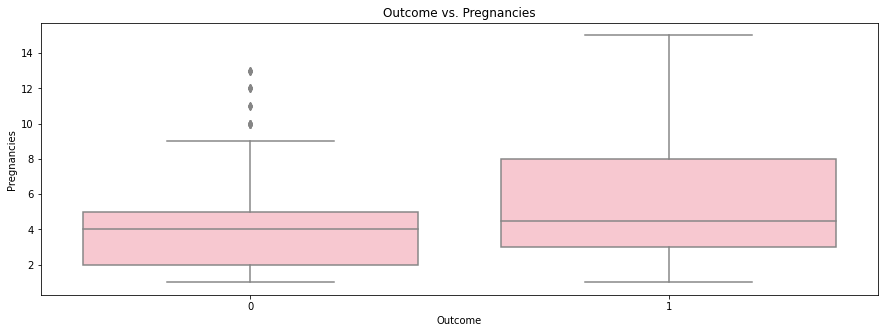

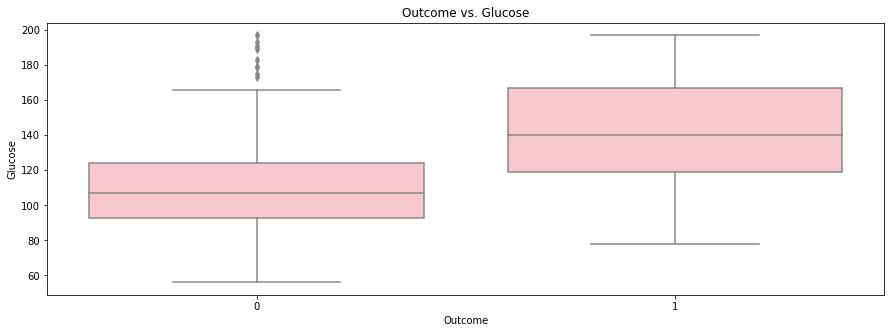

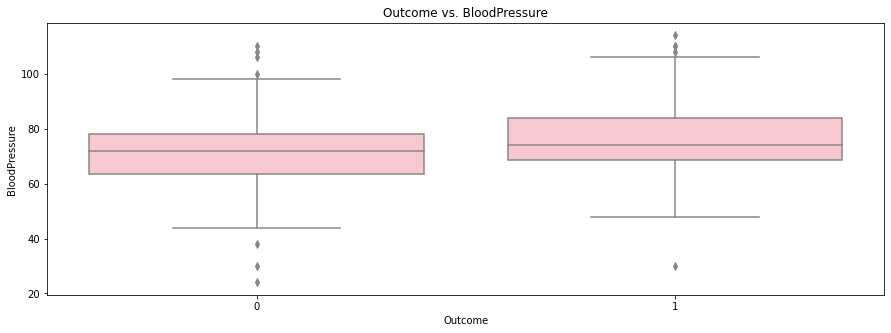

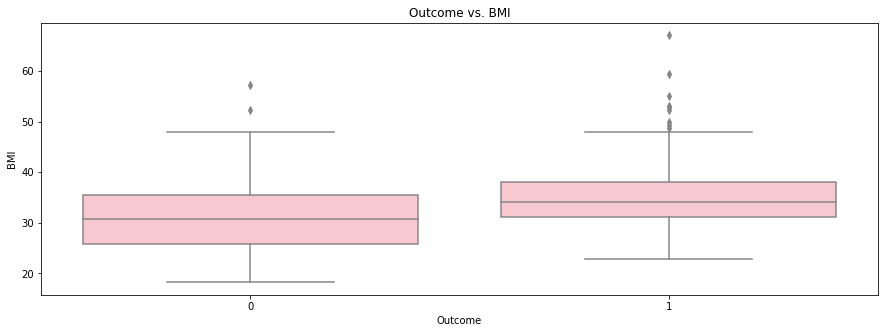

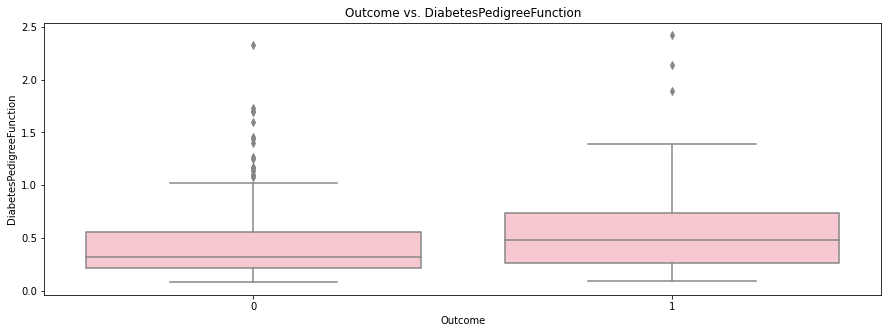

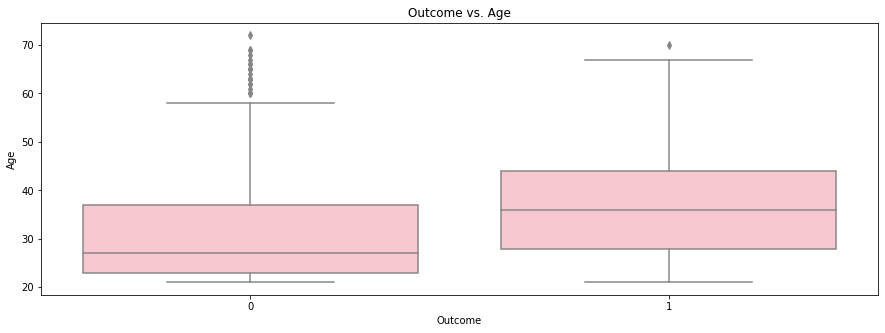

In [10]:
boxplots(df_train, 'Outcome')

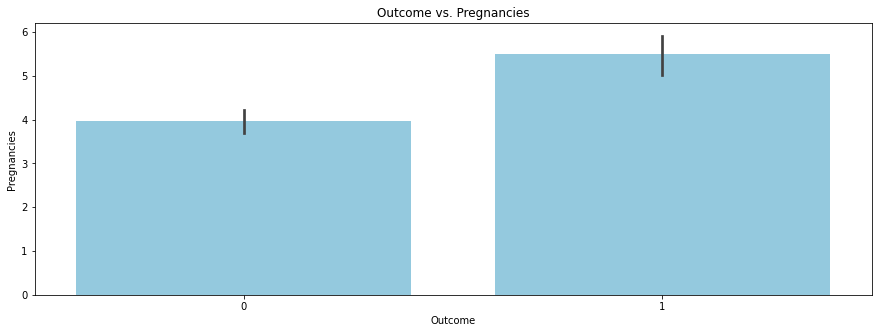

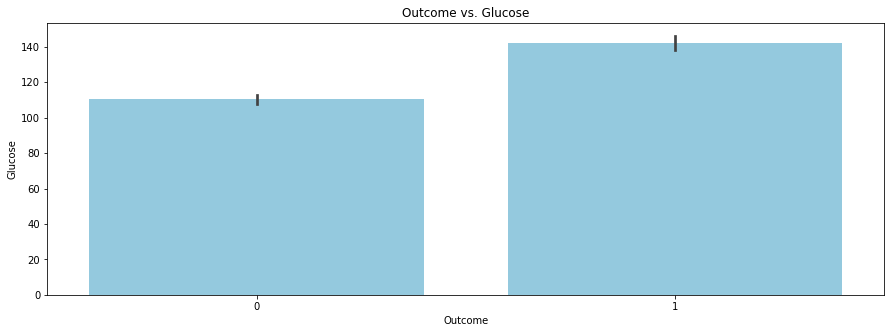

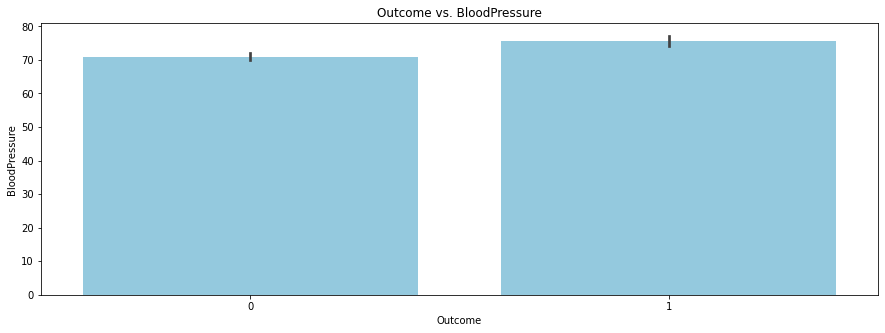

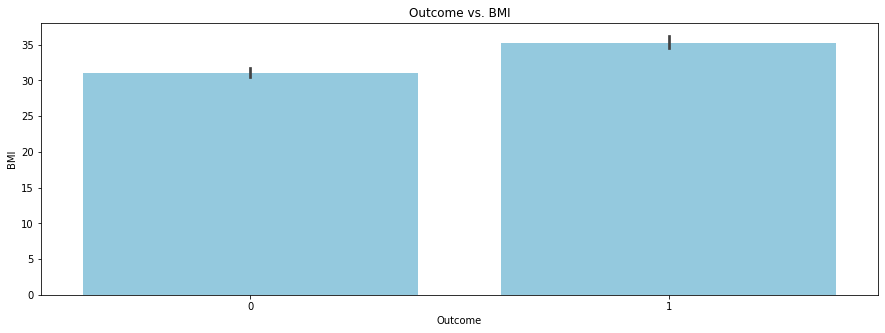

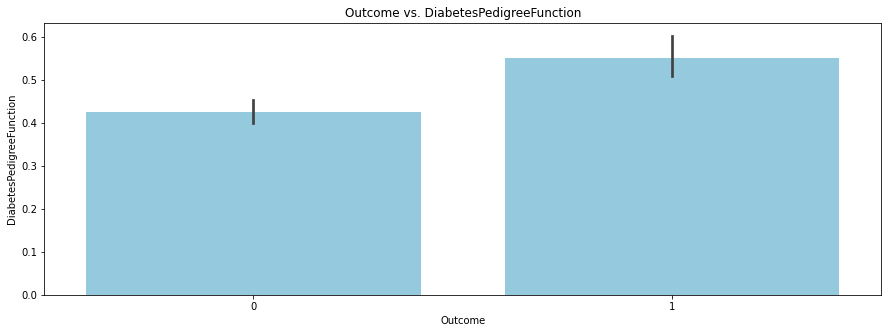

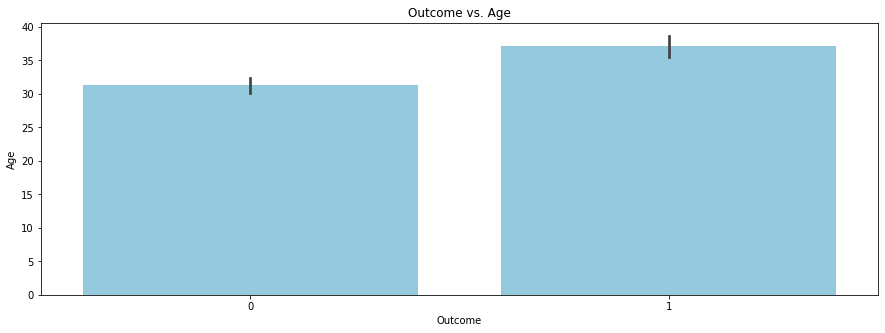

In [11]:
barplot(df_train, 'Outcome')

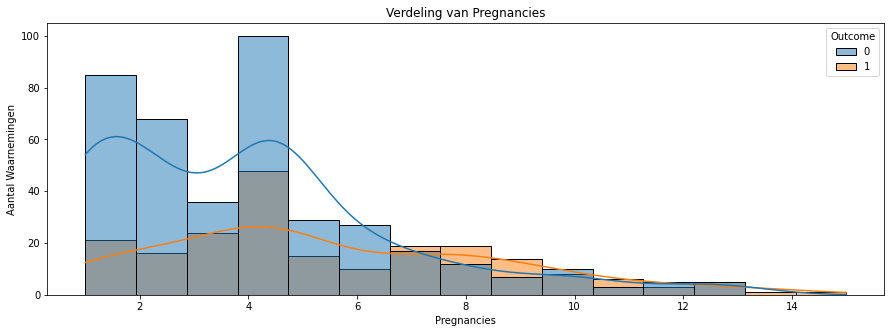

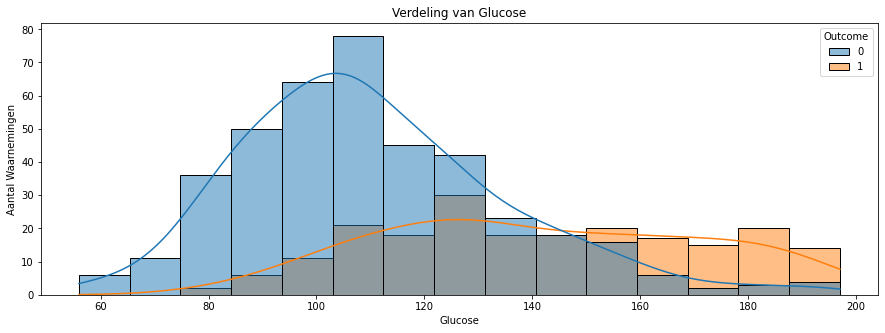

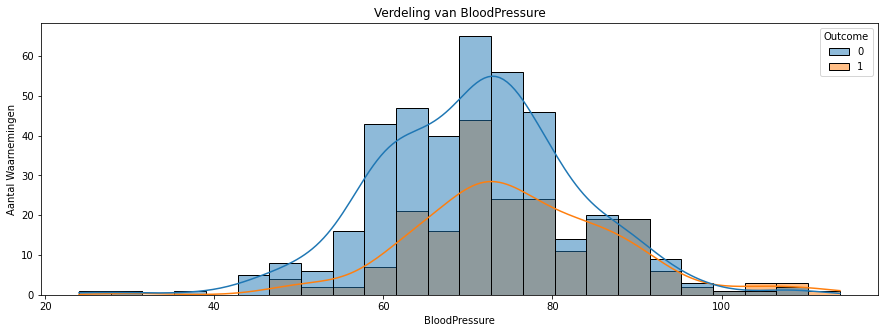

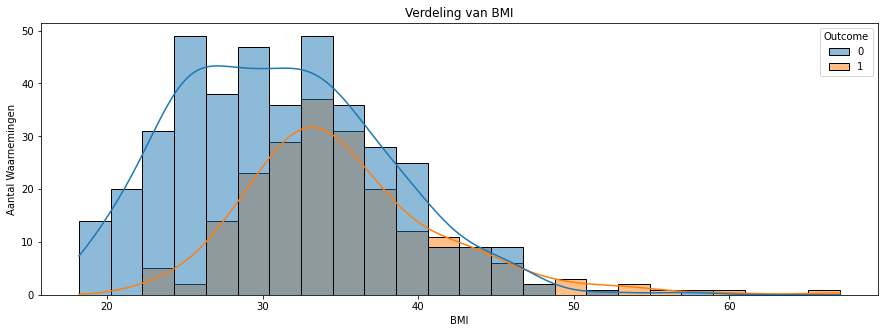

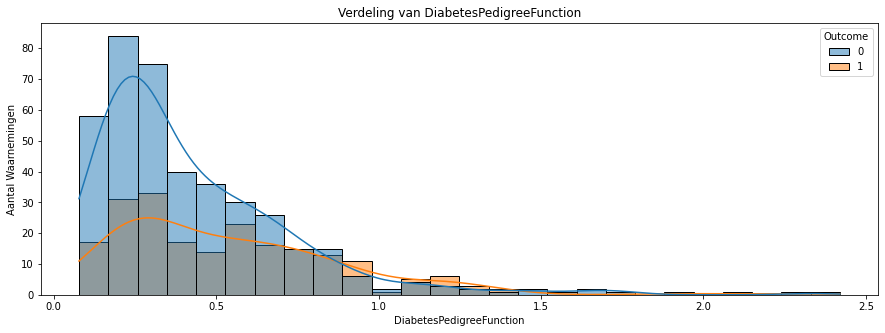

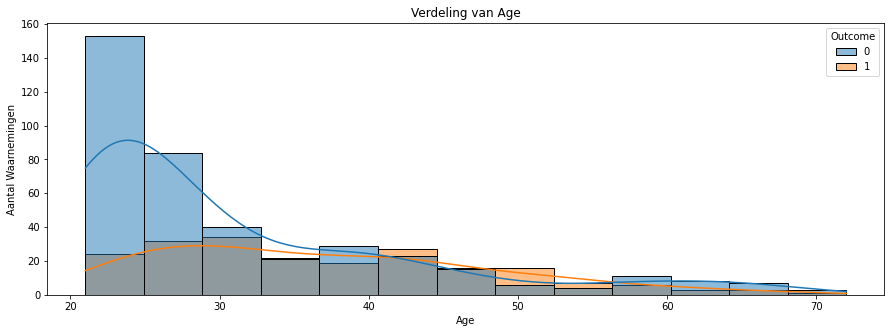

In [12]:
histplot(df_train, 'Outcome')

**Bij de visualisaties van de boxplot en barplot kun je zien dat mensen met diabetes (Outcome = 1) vaker zwanger zijn, een hogere glucose waarde hebben, hogere bloeddruk, hoger bmi, hoger diabetes pedigree function (?) hebben, en vaak ook ouder zijn
Bij de visualisatie van de Histplot zie je hetzelfde maar dan op een andere manier. Je ziet dat op het begin de stavan voornamelijk blauw (Outcome = 0) zijn en naarmate de waardes hoger worden er meer oranje (Outcome = 1) is te zien. 
De conclussie die wij hier uit trekken is dat mensen die diabetes hebben vaak hogere waardes hebben dan mensen die geen diabetes hebben.**

#### **Standaardisatie**

In een data science project, is de data standaardiseren een cruciaal onderdeel van het pre-processing van de data. In dit proces worden de variabelen omgezet in vergelijkbare schalen, zodat ze op dezelfde manier kunnen worden geïnterpreteerd en vergeleken. Als dit niet gebeurt, dan kan het model niet de juiste conclusies trekken.  

Standaardisatie heeft als hoofddoel om ervoor te zorgen dat de variabelen in een dataset vergelijkbaar zijn en op een consistente manier kunnen worden geïnterpreteerd. Hierdoor zijn analyses, modellering en visualisaties makkelijker, en het helpt bij het elimineren van vertekeningen veroorzaakt door verschillen in schaal of eenheden tussen variabelen. 

Veel machine learning algoritmen zijn gevoelig voor de schaal tussen variabelen in een dataset, door de data te standaardiseren kunnen de prestaties van een machine learning model worden verbeterd.  Als voorbeeld, een dataset die de variabelen “inkomen” en “leeftijd” bevat zal de variabele “inkomen” belangrijker beschouwen dan leeftijd omdat de schaal zoveel hoger is. Bij veel machine learning algoritmen is standaardiseren nodig, maar niet alle. Een decision-tree model is niet gevoelig voor hoge verschillen in de variabelen bijvoorbeeld. 

#### *Data standaardisatie in onze dataset* 

In onze dataset zijn de waardes redelijk vergelijkbaar, behalve de variabelen insuline en glucose. Insuline heeft een maximum van 744, en glucose 197. Terwijl de andere variabelen tussen de 10-100 liggen. Toevallig bevat Insuline zoveel missende waardes dat we ervoor hebben gekozen deze te verwijderen. Glucose aan de andere kant moet wel gestandaardiseerd worden wanneer we de machine learning modellen gaan toepassen.

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def feature_scaling(data, method='min-max', columns=None):

    if method not in ['min-max', 'standardization']:
        raise ValueError("Unsupported scaling method. Choose 'min-max' or 'standardization'.")

    if columns is None:
        numerical_columns = data.select_dtypes(include=['number']).columns
    else:
        numerical_columns = columns

    if method == 'min-max':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    scaled_data = data.copy()
    scaled_data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    return scaled_data

In [14]:
train_scaled = feature_scaling(df_train)
train_scaled.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.249246,0.462807,0.539642,0.292681,0.166565,0.240499,0.342020
std,0.211887,0.215829,0.133553,0.141059,0.140565,0.232381,0.474773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.071429,0.306738,0.444444,0.192229,0.068318,0.058824,0.000000
50%,0.249246,0.425532,0.539642,0.290389,0.122758,0.156863,0.000000
75%,0.357143,0.595745,0.622222,0.374233,0.235056,0.392157,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## ***Machine Learning en Metrics***

#### *De vorm van Machine Learning*
Bij deze opdracht is er sprake van een classificatie. De target variabele, 'Outcome', heeft twee mogelijke waarden, dit zijn 0 of 1. De waarde 0 geeft aan dat het individu waarvan de data afkomstig is geen diabetes heeft, bij een waarde van 1 zou het individu wel diabetes hebben.

#### *De metrics van classificatie*
Bij een classificatie worden 4 verschillende metrics gebruikt: accuracy, precision, recall en f1-score. De accuracy is redelijk vanzelfsprekend, deze metric houdt het percentage waarden dat correct is voorspeld in. De andere drie metrics worden hieronder uitgelegd, met behulp van een confusion matrix.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class Classificatie:
    """ 
    Een class die gebruikt wordt om een voorspellend model te maken. 
    
    Atributes:
    ------------------
    df : DataFrame
        Het dataframe waar het model op gebruikt wordt.
        
    target : str
        Naam van de kolom die voorspelt wordt.
        
    Methods:
    ----------------
    
    model_logreg(self, c_value = 1.0, penalty = 'l2')
        Een method die het classification report returned. Dit rapport wordt gemaakt door de
        classification_report method van SKLearn en bevat o.a. de Precision, Recall en Accuracy.
    """
    
    def __init__(self, df, target):
        """
        De constructor van de class. Deze maakt X en y aan om deze vervolgens
        te splitten in een train en test set voor het modelleren.
        
        Parameters:
        -------------------
        df : DataFrame
            Het dataframe waar het model op gebruikt wordt.
        
        target : str
            Naam van de kolom die voorspelt wordt.
        """
        
        self.X = df.drop(target, axis = 1)
        self.y = df[target]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state = 42)
    
    def model_logreg(self, c_value = 1.0, penalty = 'l2', rapport = True):
        """
        Een method die het classification report returned. Dit rapport wordt gemaakt door de
        classification_report method van SKLearn en bevat o.a. de Precision, Recall en Accuracy.
        
        Parameters:
        -------------------
        c_value: float, default = 1.0
            Inverse van regularisatiekracht; moet een positieve floats zijn. Net als bij ondersteunende vectormachines, 
            specificeren kleinere waarden een sterkere regularisatie.
    
        penalty: str, default ='l2'
            Bepaald of er een penalty gebruikt wordt en welke er gekozen wordt.

        rapport: bool, default = True
            Met rapport geef je aan of je het classificatie rapport
            te zien wilt krijgen
            
        Returns:
        ------------------
        print : str
            Het rapport met daarin de waardes over hoe goed de voorspelling in elkaar zit.
        
        """
        
        #model aanmaken en fitten
        self.logreg = LogisticRegression(penalty = penalty, solver = 'liblinear', C = c_value, random_state = 42, max_iter = 500)
        self.logreg.fit(self.X_train, self.y_train)
        
        #berekenen y_hat en tonen classification rapport
        self.y_hat = self.logreg.predict(self.X_test)
        
        # optionele classification report
        if rapport is True:
            self.report = classification_report(self.y_test, self.y_hat)
            return print('Rapport:', self.report, sep='\n')
        else:
            return None
        
    def confusion_matrix(self):
        """
        Een functie die een confusionmatrix opsteld
        """

        # maken van de confusion matrix
        cm = confusion_matrix(self.y_test, self.y_hat)
        cmd = ConfusionMatrixDisplay(cm, display_labels=['No diabetes','Diabetes'])
        cmd.plot()
        plt.show()

        # Aangeven van de vakken voor berekening metrics
        TP = cm[1,1]
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]

        # Berekenen van de metrics
        precision = TP / ( TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        
        print(f"Precision: {precision}\n"\
              f"Recall: {recall}\n"\
              f"F1_score: {f1}")

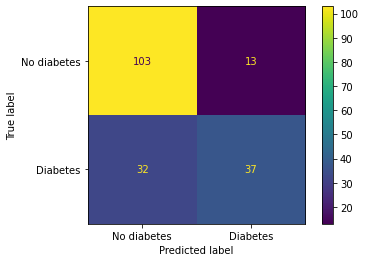

Precision: 0.74
Recall: 0.5362318840579711
F1_score: 0.6218487394957984


In [16]:
model = Classificatie(train_scaled, 'Outcome')
model.model_logreg(rapport=False)
model.confusion_matrix()

Zoals er te zien is in de Confusion Matrix, zijn er vier verschillende vlakken. Aan de hand van deze vier vlakken worden de metrics precision, recall en f1 berekend. De vier vlakken kunnen wisselen van locatie aan de hand van de context, ondanks het wisselen van locatie blijven de 4 vlakken wel met dezelfde namen. Deze namen zijn: 
- True Positive (Uitkomsten tonen en zijn gewild)
- False Positive (Uitkomsten tonen zich als gewild, maar in de werkelijkheid zijn ze ongewild)
- True Negative (Uitkomsten tonen en zijn ongewild)
- False Negative (Uitkomsten tonen zich als ongewild, maar zijn in werkelijkheid gewild)

De precision metric is de bepaling van het deel positieve voorspellingen dat juist is voorspeld. Een hoge precision toont een laag aantal foutief positieve voorspellingen. De berekening ziet er als volgt uit: $\frac{TP}{(TP + FP)}$

De recall metric is de bepaling van het deel daadwerkelijk positieve uitkomsten dat juist is voorspeld. Een hoge recall toont aan dat het model weinig positieve gevallen over het hoofd ziet. De berekening ziet er als volgt uit: $\frac{TP}{(TP + FN)}$

De F1 score is een bepaling die zowel de precision als de recall in waarde neemt. Hierdoor geeft een hoge f1 score weer dat er op beide metrics goed is gescoord. De f1 score wordt bepaald door de volgende berekening: $ 2 * \frac{(Precision * Recall)}{(Precision + Recall)}$

#### *Welke metric?*

In ons geval willen we voorspellen of iemand diabetes heeft. Omdat diabetes vrij veel impact op de gezondheid van een persoon heeft, beredeneren wij dat het belangrijker is om zo min mogelijk voorspellingen te hebben die diabetes missen. In context van een confusion matrix, **zijn volgens ons** de false negatives belangrijker om te voorkomen dan de false positives. Op basis hiervan kiezen wij voor de metric recall. Met recall wordt gekeken hoeveel van de werkelijk positieve voorspelling correct zijn voorspeld. Als de recall hoog is, mist het model nauwelijks positieve gevallen.

Hoewel wij persoonlijk de recall het belangrijkste vinden, zal op Kaggle de F1 scores van de voorspellingen worden gebruikt. Om deze reden zal er getest worden met de F1 score i.p.v. de recall.

## ***Modelleren***

Eerst zal de data uit het test dataframe **omgezet #moet weg** aangepast worden om overeen te komen met de data uit de train dataset.

In [17]:
# Copy maken van dataset
df_test = data_test.copy()

# Aanmaken X_kolommen voor replace
df_test[X_kolommen] = df_test[X_kolommen].replace(0, np.nan)

# Berekenen en vullen gem
gem = df_test.mean()
df_test.fillna(gem, inplace=True)

# Weghalen van kolommen wegens te hoog aantal nulwaarden
df_test.drop('Insulin', axis=1, inplace=True)
df_test.drop('SkinThickness', axis=1, inplace=True)

df_test.drop('p_id', axis = 1, inplace=True)

test_scaled = feature_scaling(df_test)
test_scaled.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,0.219669,0.512292,0.387480,0.445826,0.168873,0.202381
std,0.188787,0.196715,0.151428,0.215945,0.157059,0.190444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.062500,0.361290,0.292683,0.277778,0.063452,0.050000
50%,0.219669,0.503226,0.388862,0.431746,0.126211,0.133333
75%,0.312500,0.622581,0.487805,0.605556,0.229926,0.316667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Nu dit is gebeurt zal de train_test_split functie van SKLearn ons helpen om de data op een goede manier te splitsen, zodat we de data kunnen gebruiken om de modellen te trainen.

In [18]:
X = train_scaled.drop('Outcome', axis=1)
y = train_scaled['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Nu de data gesplitst is, wordt er een functie aangemaakt om op een gemakkelijke manier de voorspellingen van een model om te zetten naar een csv bestand.

In [19]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(test_scaled)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'p_id': data_test['p_id'],
        'Outcome': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

Nu zal de standaard CV methode aangemaakt worden, zodat deze code zich niet meerdere keren herhaald bij de GridSearch stappen.

In [20]:
cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=42)

Nu alle voorbereidende stappen zijn gedaan kunnen de modellen worden gemaakt, verbeterd en gebruikt om zo sterk mogelijke voorspellingen te creeëren.

### ***Logistische Regressie***

#### **De werking van LR** 
Bij logistice regressie wordt de waarde van een afhankelijke variabele voorspelt op basis van een of meerdere onafhankelijke variabelen. Logistische regressie wordt gebruikt bij classificatie problemen.

#### **Loss functie**

$BCE = -\frac{1}{N} \sum_{i=1}{N} \left[ y_true \log(\hat{y_pred}) + (1-y_true) \log(1-\hat{y_pred}) \right]$

y_true is 1 of 0 (positief of negatief)

y_pred is een kans tussen 0 en 1

#### **Gradient descent**

**Gradien descent is een optimalisatie algoritme dat de erors minimaliseert tussen de true en predicticted resultaten. De formule van gradient descent is  𝑥𝑛𝑒𝑤=𝑥𝑜𝑙𝑑−𝛼𝑑𝑦𝑑𝑥
  waarbij 𝑥𝑛𝑒𝑤 de bijgewerkte waarde van de onafhankelijke variabele na één stap is, 𝑥𝑜𝑙𝑑 is de vorige waarde van de onafhankelijke variabele, 𝑑𝑦𝑑𝑥 de gradiënt (afgeleide) van deze functie ten opzichte van de onafhankelijke variabele is en 𝛼 is de learning rate, deze bepaalt de grootte van de stap die wordt genomen.**

**𝑦=𝑥2−𝑥−6 de gradient van deze functie is f'(x) = 2x-1. De wiskundige formule van het berekenen van de gradient is xn = nx*n-1**



**(Gradient Descent in Machine Learning, z.d.)**


#### **Regularisatie**
De vorm van regularisatie die van toepassing is op logistic regression is de L1 en L2 regularisatie. Ook wel de Lasso (L1) en ridge (L2) regularisatie genoemd. Door regularisatie toe te passen, wordt een complex model tijdens het trainen vereenvoudigd. 
L1 voegt de “absolute waarde van de grootte” (“absolute value of magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie.
L2 voegt de “kwadratische omvang” (“squared magnitude”) van de coëfficiënt als penalty term toe aan de loss-functie. **(Nagpal, 2022)**


**Wiskundige formule voor L1 is:
L1(θ) = λ * Σ|θj|**

**Waarbij
θj L1-norm van de gewichtsvector
λ is de regularisatieparameter**

**wiskundige formule voor L2 is:
L2(θ) = λ * Σ(θj^2)**

**waarbij
θj L2-norm van de gewichtsvector
λ is de regularisatieparameter**

**Misschien zelfde als bij SVM hier neerzetten?**

Het verminderen of verwijderen van modelparameters is een methode om overfitting te voorkomen.

Nu het duidelijk is wat Logistische Regressie inhoud, kan er een model worden opgesteld.

In [21]:
# Aanmaken LR model
lr = LogisticRegression(solver='liblinear',
                        random_state=42)

# Fitten en voorspellen met LR
y_pred = lr.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

F1 score: 0.6352941176470589


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [22]:
# Aanmaken parameter dictionary
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [500, 1000, 2000, 5000]
}

# Uitvoeren van Grid Search CV
gs_lr = GridSearchCV(estimator=lr,
                    param_grid=param_lr,
                    cv=cv,
                    scoring='f1',
                    n_jobs=-1)

# Fitten van Grid Search en bekijken uitkomst
gs_lr.fit(X_train, y_train)
print(f"Beste f1: {gs_lr.best_score_}")
print(f"Beste parameters:\n{gs_lr.best_params_}")

Beste f1: 0.6259493599245204
Beste parameters:
{'C': 10, 'max_iter': 500, 'penalty': 'l1'}


Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [23]:
# Aanmaken verbeterd LR model
lr_tuned = LogisticRegression(solver='liblinear',
                              C=10,
                              max_iter=500,
                              penalty='l1',
                              random_state=42)

# Fitten en voorspellen verbeterd LR model
y_pred = lr_tuned.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

# Aanmaken CSV
# submissie(lr_tuned, 'LR')

F1 score: 0.651685393258427


### ***Decision Tree***

In dit gedeelte wordt een decision tree model gemaakt. Allereerst moeten we weten wat een decision tree model is, en hoe het werkt. Een decision tree model is een vorm van supervised machine learning. In dit geval wordt een decision tree classifier gebruikt omdat dit een classificatie probleem is. Het werkt door de dataset recursief te verdelen in "vertakkingen" op basis van de waarden van de invoerfuncties. Deze splitsingen creëren een structuur die op een boom lijkt, waarbij elke vertakking een beslissing of een test op een kenmerk vertegenwoordigt. En op die gesplitste data wordt weer een beslissing genomen, en zo vertakt het model tot we bij de "bladeren" komen. En net zoals bij een boom, noemen we de eerste splitsing de "wortel", en eindigen we bij het blad. Na het blad stopt het model met splitsen.

TOEVOEGEN: criteria

hyperparameters

pruning + uitleg

<i>Uitleg mist nog</i>

In [24]:
# Aanmaken DT model
dt = DecisionTreeClassifier(random_state=42)

# Fitten en voorspellen met DT
y_pred = dt.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

F1 score: 0.6451612903225806


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [25]:
# Aanmaken parameter dictionary
param_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 20],
    "min_samples_leaf": [2, 4, 8]
}

# Uitvoeren van Grid Search CV
gs_dt = GridSearchCV(estimator=dt,
                     param_grid=param_dt,
                     cv=cv,
                     scoring="f1",
                     n_jobs=-1)

# Fitten van Grid Search en bekijken uitkomst
gs_dt.fit(X_train, y_train)
print(f"Beste f1: {gs_dt.best_score_}")
print(f"Beste parameters:\n{gs_dt.best_params_}")

Beste f1: 0.5992862882389927
Beste parameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 8}


Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [26]:
# Aanmaken verbeterd DT model
dt_tuned = DecisionTreeClassifier(criterion='gini',
                                  max_depth=5,
                                  min_samples_leaf=8,
                                  random_state=42)

# Fitten en voorspellen verbeterd DT model
y_pred = dt_tuned.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

# Aanmaken CSV
# submissie(dt_tuned, 'dt')

F1 score: 0.5128205128205128


## ***Random forest***

Random Forest is een vorm van een ensemble model dat gebaseerd is op Decision Tree.

### *Werking van het Random Forest-model:*
**Bootstrap Aggregating (Bagging):** Random Forest bestaat uit een ensemble van Decision Trees. Elk van deze trees wordt getraind op een steekproef uit de train data, deze is opgesteld door willekeurig rijen te nemen uit de dataset met teruglegging. Dit wordt bootstrapping genoemd.

**Random Feature Selectie:** Bij elke instantie van een Random Forest wordt slechts een deel van de beschikbare functies gekozen om de splitsing te maken. Hierdoor krijgen de individuele trees verschillende perspectieven op de gegevens.

**Voting of Gemiddelde:** In plaats van één enkele Decision Tree om voorspellingen te doen, combineert een Random Forest de voorspellingen van alle bomen in de ensemble door middel van een meerderheidsstemming (voor classificatie) of een gemiddelde (voor regressie).

**Overfitting beperken:** Door de bovenstaande technieken van willekeur en aggregatie te gebruiken, helpt een Random Forest overfitting te verminderen.

### *Performance in vergelijking met andere tree-based modellen:*
In vergelijking met enkele Decision Trees heeft Random Forest over het algemeen betere prestaties omdat het de neiging tot overfitting vermindert en de nauwkeurigheid van de voorspellingen verhoogt.

Nu duidelijk is hoe Random Forest werkt, zal er een model gemaakt worden.

In [27]:
# Aanmaken RF model
rf = RandomForestClassifier(random_state=42,
                            n_jobs=-1)

# Fitten en voorspellen met RF
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

F1 score: 0.6736842105263158


Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [28]:
# Aanmaken parameter dictionary
param_rf = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20]
}

# Uitvoeren van Grid Search CV
gs_rf = GridSearchCV(estimator=rf, 
                     param_grid=param_rf, 
                     cv=cv,
                     scoring='f1',
                     n_jobs=-1)

# Fitten Grid Search en bekijken uitkomst
gs_rf.fit(X_train, y_train)
print(f"Beste f1: {gs_rf.best_score_}")
print(f"Beste parameters:\n{gs_rf.best_params_}")


KeyboardInterrupt



### *Pruning in Random Forest*
Hoewel het niet **per se** nodig is om pruning toe te passen op Random Forest, is het bij het maken van ons model wel van toepassing gekomen. Door de max_depth aan te passen van None naar 5 is de accuracy van het model verbeterd **met** ca. 0.04. Dit staat gelijk aan ongeveer 4% accuracy.

Nu de optimale hyperparameters gekozen zijn **hier moet komma** worden deze ingevuld bij een Random Forest model, om zo de voorspellingen goed aan te maken. Dit wordt ook gedaan zodat de GridSearch niet elke keer uitgevoerd moet worden als er op Run All word geklikt.

Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [ ]:
# Aanmaken verbeterd RF model
rf_tuned = RandomForestClassifier(criterion='entropy',
                                  n_estimators=200,
                                  max_depth=10,
                                  random_state=42,
                                  n_jobs=-1)

# Fitten en voorspellen verbeterd RF model
y_pred = rf_tuned.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

# Aanmaken CSV
# submissie(rf_tuned, 'RFC')

## ***Gradient Boosting***

Gradient boosting is een manier van machine learning gebruikt in regressie and classificatieproblemen waarbij meerdere zogenaamde "weak learners", modellen die weinig aannames doen over de data, als een "ensemble" of samenwerking voorspellingen doen over de data. Er zijn meerdere redenen waarom er voor gradient boosting gekozen **wordt** in plaats van andere modellen. Omdat er bij gradient boosting gebruik **wordt** gemaakt van meerdere modellen die de fouten van vorige modellen corrigeren, kan het accurater zijn. Door het gebruik van weak learners is gradient boosting ook bestendiger **tegen** overfitting.

Er zijn ook een paar nadelen verbonden aan het gebruik van gradient boosting. Het is een stuk complexer dan een standaard model, en deze complexiteit en het gebruik van meerdere bomen zorgt er voor dat de tijd die het kost om het model te maken een stuk langer kan zijn dan een standaard model.

In [ ]:
# aanmaken gradient boosting model
gb = GradientBoostingClassifier(random_state = 42)

In [ ]:
# gebruik van gridsearch om de beste parameters te zoeken
param_gb = {"criterion":["friedman_mse", "squared_error"], "learning_rate":[0.1, 5000, 7500, 8000, 8500], "n_estimators":[1, 3, 5], "max_depth":[2, 3 ,5], "min_samples_leaf":[2, 4, 8]}

gs_gb = GridSearchCV(gb, param_gb, cv=cv, scoring="recall", n_jobs=-1)

gs_gb.fit(X_train, y_train)

gs_gb.best_params_

In [ ]:
# model met beste parameters voor Kaggle submissie
gb_sub = GradientBoostingClassifier(criterion="friedman_mse", learning_rate=8000, max_depth=5, min_samples_leaf=4, n_estimators=1)

y_pred_gb = gb_sub.fit(X_train, y_train).predict(test_scaled)
y_pred_gb = y_pred_gb.astype(int)
y_pred_gb

## ***Support Vector Machines***

#### *Werking van SVM*
Een Support Vector Machine is een model dat ingezet kan worden bij classificatie en regressie problemen. Het model heeft als doel om een hyperplane (de beslissingsgrens) te vinden, waarbij de datapunten in verschillende klassen worden gescheden en waarbij een zo groot mogelijke marge tussen de klassen zit. In een deel van de ML-problemen zal de hyperplane van een SVM model een lineaire vergelijking **aannemen**. Aan de hand van een wiskundig voorbeeld zal dit worden uitgelegd:

Elk gegeven punt in de grafiek voor SVM zal bestaan uit een waarde (x, y). Het doel van SVM is om een grens te maken tussen de punten, om zo deze punten te classificeren. In onze dataset ziet de formule voor deze lijn er als volgt uit:

$w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5 + w_6x_6 + b = 0$. 

Bij deze formule zijn $w$ de gewichten die de helling bepalen, $b$ is de bias term die de verschuiving bepaald en $x$ staat voor de betreffende kolom. De verschillende getallen achter de $w$ en de $x$ staan voor de verschillende parameters van het model. Het doel is dan om, aan de hand van de bovenstaande formule, een lijn te trekken waardoor de voorspellingen zo accuraat mogelijk worden voorspeld. Dit terwijl de marge tussen de punten en de lijn zo groot mogelijk blijft. De uitkomsten van de formule tonen aan waar het punt zou moeten liggen, aan de positieve of de negatieve kant van de lijn. Om de marge vervolgens te optimaliseren gebruiken we de volgende formule: $\frac{2}{||w||}$. Hierbij is $||w||$ de norm van de vector, dit is veel gebruikt om de lengte van een vector te meten.

In sommige gevallen zijn de gegevens niet goed lineair scheidbaar, in dit geval wordt de kerneltruc toegepast. Een kernel is een functie die de gegevens naar een hogere dimensionale ruimte projecteert, waar ze mogelijk lineair scheidbaar zijn. De kerneltruc maakt het mogelijk om deze projectie te vermijden en berekeningen direct in de oorspronkelijke ruimte uit te voeren, waardoor SVM geschikt is voor complexe datasets. Kortom: de kerneltruc helpt SVM bij het modelleren van niet-lineaire beslissingsgrenzen.

#### *Loss functie*
De loss functie bij SVM ziet er als volgt uit:

$Loss = \sum_{i=1}^{N} max(0,1 - y_i(w^Tx_i + b)) + \lambda||w||^2$

Uitleg van letters bij Loss functie:
- $N$: Het aantal datapunten
- $x_i$: een datapunt
- $y_i$: de label van datapunt $x_i$
- $w$: de gewichtsvector van de hyperplane
- $b$: de bias-term
- $\lambda$: de regularisatieparameter
- $||w||^2$: de L2-norm van de gewichtsvector

Het eerste deel van de functie ($\sum_{i=1}^{N} max(0,1 - y_i(w^Tx_i + b))$) meet hoe ver alle punten aan de verkeerde kant van de lijn staan. Als het label correct is voorspeld is de loss gelijk aan 0, zo niet dan neemt de loss meer toe naarmate de fout groter is. Het tweede deel van de functie ($\lambda||w||^2$) is de toegepaste vorm van regularisatie, in de bovenstaande functie is er gebruikt gemaakt van Ridge regularisatie. In de onderstaande tekst worden Ridge en Lasso, de vormen van regularisatie, besproken en uitgelegd.

#### *Regularisatie bij SVM*
**Lasso (L1)**<br>
Lasso (ook bekend als L1-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de absolute waarden van de gewichten. Deze vorm van regularisatie wordt geschreven als: $\lambda||w||_1$. Bij dit deel is $\lambda$ regularisatieparameter en $||w||_1$ de L1-norm van de gewichtsvector. Het effect dat Lasso heeft is dat het sommige gewichten reduceert to nul. Hierdoor worden sommige kenmerken volledig genegeeerd, waardoor feature selectie mogelijk wordt gemaakt. Door middel van feature selectie wordt de kans op overfitting verminderd.

**Ridge (L2)**<br>
Ridge (ook bekend als L2-regularisatie) voegt een term toe aan de loss functie die in gelijke verhouding staat tot de kwadraten van de gewichten. Deze vorm van regularisatie wordt geschreven als: $\lambda||w||^2$. Bij dit deel is $\lambda$ regularisatieparameter en $||w||^2$ de L2-norm van de gewichtsvector. Het effect dat Ridge heeft is dat het de waarden van gewichten dicht naar de nul brengt, maar niet nul maakt. De ridge manier gaat de mogelijke overfitting tegen door te zorgen dat de gewichten geen te grootte waarden kunnen aannemen.

Nu er kennis is gemaakt met het model kan er worden gecodeerd in python:

In [ ]:
# Aanmaken SVM model
svmc = SVC(random_state=42)

# Fitten en voorspellen met SVM
y_pred = svmc.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

Nu het eerste model is gemaakt gaan we deze tunen met behulp van GridSearchCV. Hiervoor maken we een dictionary aan met de parameters die we willen testen, vervolgens kan GridSearch gebruikt worden.

In [ ]:
# Aanmaken parameter dictionary
param_svm = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1.0, 10.0],
    'degree': [1, 2, 3]
}

# Uitvoeren van Grid Search CV
gs_svm = GridSearchCV(estimator=svmc,
                      param_grid=param_svm,
                      cv=cv,
                      scoring='f1',
                      n_jobs=-1)

# Fitten Grid Search en bekijken uitkomst
gs_svm.fit(X_train, y_train)
print(f"Beste f1: {gs_svm.best_score_}")
print(f"Beste parameters:\n{gs_svm.best_params_}")

Met deze optimale parameters gaan we de voorspellingen opnieuw maken. Deze kunnen vervolgens in een csv bestand worden omgezet om ingeleverd te worden op Kaggle.

In [ ]:
# Aanmaken verbeterd SVM model
svmc_tuned = SVC(kernel='linear',
                 C=10.0,
                 degree=1,
                 gamma=0.001,
                 random_state=42)

# Fitten en voorspellen verbeterd SVM model
y_pred = svmc_tuned.fit(X_train, y_train).predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred)}')

# Aanmaken CSV
# submissie(svmc_tuned, 'SVM')

# Bronvermelding

powerpoints uit de lessen **(LR en ADA boosting)**

datacamp **(LR en ADA boosting)**

Nagpal, A. (2022, 05 januari). L1 and L2 Regularization Methods, Explained. Builtin. Van https://builtin.com/data-science/l2-regularization. **(LR)**


Gradient Descent in Machine Learning. (z.d.). Javapoint. Van https://www.javatpoint.com/gradient-descent-in-machine-learning **(LR)**
